In [9]:
import cudf
import cupy as cp
import matplotlib.pyplot as plt
from cuml.cluster import DBSCAN
from cuspatial import haversine_distance
import pandas as pd
from cuspatial import haversine_distance
from cuspatial import GeoSeries

In [2]:
# Load using cuDF
df_cases = cudf.read_csv("./data/WHO-COVID-19-global-data-2.csv")
df_locs = cudf.read_csv("./data/world_country_and_usa_states_latitude_and_longitude_values.csv")

# Clean column names
df_cases = df_cases.rename(columns={
    ' Country': 'Country',
    ' Country_code': 'Country_code',
    ' WHO_region': 'WHO_region'
})
df_locs = df_locs.rename(columns={
    'country': 'Country',
    'latitude': 'lat',
    'longitude': 'lon'
})

# Convert to pandas to safely parse datetime
df_cases_pd = df_cases.to_pandas()
df_cases_pd['Date_reported'] = pd.to_datetime(df_cases_pd['Date_reported'], errors='coerce')
df_cases_pd = df_cases_pd.dropna(subset=['Date_reported'])

# Convert back to cuDF
df_cases = cudf.from_pandas(df_cases_pd)

# Merge and clean
df = df_cases.merge(df_locs, on="Country", how="inner")
df = df.dropna(subset=["lat", "lon"])
df = df[df['Date_reported'] > '2021-01-01']

print("✅ Date parsing fixed. Cleaned data rows:", len(df))


✅ Date parsing fixed. Cleaned data rows: 79596


In [3]:
df['prev_lat'] = df['lat'].shift(1).fillna(df['lat'])
df['prev_lon'] = df['lon'].shift(1).fillna(df['lon'])


In [4]:
print(df.columns)


Index(['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases',
       'Cumulative_cases', 'New_deaths', 'Cumulative_deaths', 'country_code',
       'lat', 'lon', 'usa_state_code', 'usa_state_latitude',
       'usa_state_longitude', 'usa_state', 'prev_lat', 'prev_lon'],
      dtype='object')


In [5]:
df.columns = df.columns.str.strip()


In [6]:
print(df.columns)


Index(['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases',
       'Cumulative_cases', 'New_deaths', 'Cumulative_deaths', 'country_code',
       'lat', 'lon', 'usa_state_code', 'usa_state_latitude',
       'usa_state_longitude', 'usa_state', 'prev_lat', 'prev_lon'],
      dtype='object')


In [8]:
print(df[["prev_lon", "prev_lat", "lon", "lat"]].head())


    prev_lon   prev_lat        lon        lat
0  17.873887 -11.202692  17.873887 -11.202692
1  17.873887 -11.202692  17.873887 -11.202692
2  17.873887 -11.202692  17.873887 -11.202692
3  17.873887 -11.202692  17.873887 -11.202692
4  17.873887 -11.202692  17.873887 -11.202692


In [11]:

p1 = GeoSeries.from_xy(df["prev_lon"].to_numpy(), df["prev_lat"].to_numpy())


In [12]:
import geopandas as gpd

# Convert GPU DataFrame to CPU (pandas) first
pdf = df.to_pandas()

# Then create GeoDataFrame safely
gdf = gpd.GeoDataFrame(
    pdf,
    geometry=gpd.points_from_xy(pdf["lon"], pdf["lat"]),
    crs="EPSG:4326"
)


In [13]:
import pandas as pd

# Load cleaned dataset
pdf_clean = pd.read_csv("cleaned_sample.csv")  # or your actual path

# Now safely sample
subset = pdf_clean.sample(n=min(198, len(pdf_clean)), random_state=42)


In [14]:
from sklearn.metrics.pairwise import haversine_distances
import numpy as np

coords = np.radians(subset[["lat", "lon"]])
dist_matrix = haversine_distances(coords, coords)
dist_matrix_km = dist_matrix * 6371.0


In [15]:

# Sample from unique coordinate locations
unique_coords = pdf_clean.drop_duplicates(subset=["lat", "lon"])
subset = unique_coords.sample(n=min(198, len(unique_coords)), random_state=42)


In [17]:

from sklearn.metrics.pairwise import haversine_distances
import numpy as np

# Convert to radians
coords_rad = np.radians(subset[["lat", "lon"]])


In [18]:
# Compute haversine distance matrix
dist_matrix = haversine_distances(coords_rad, coords_rad) * 6371.0  # Earth radius in km


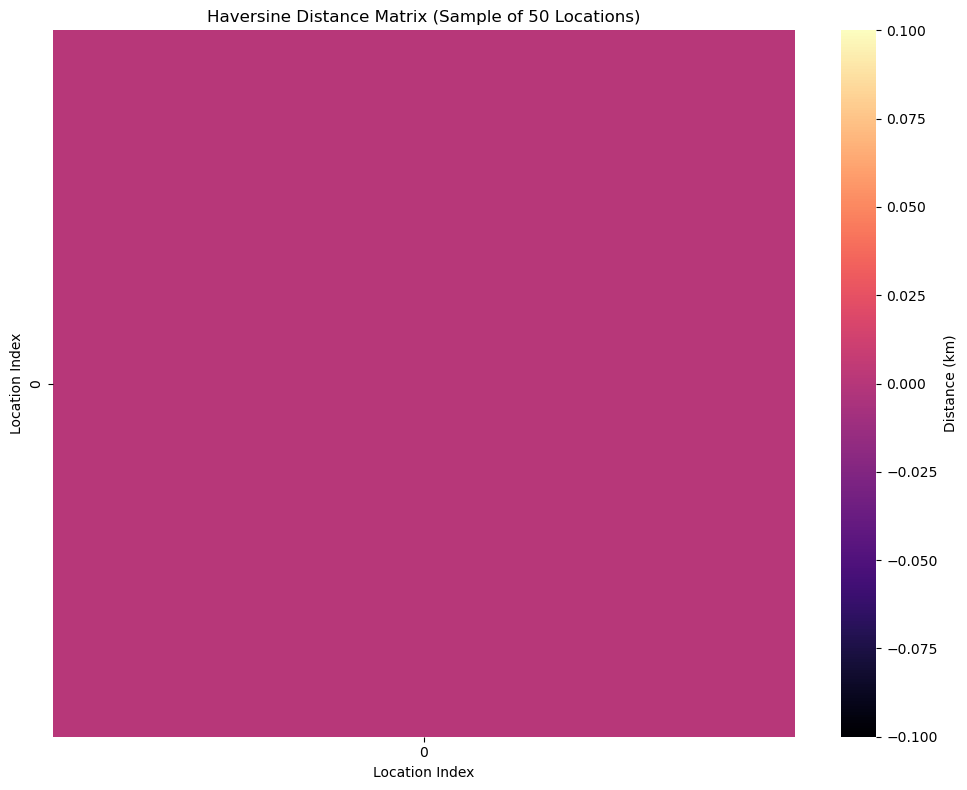

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix[:50, :50], cmap="magma", cbar_kws={"label": "Distance (km)"})
plt.title("Haversine Distance Matrix (Sample of 50 Locations)")
plt.xlabel("Location Index")
plt.ylabel("Location Index")
plt.tight_layout()
plt.show()


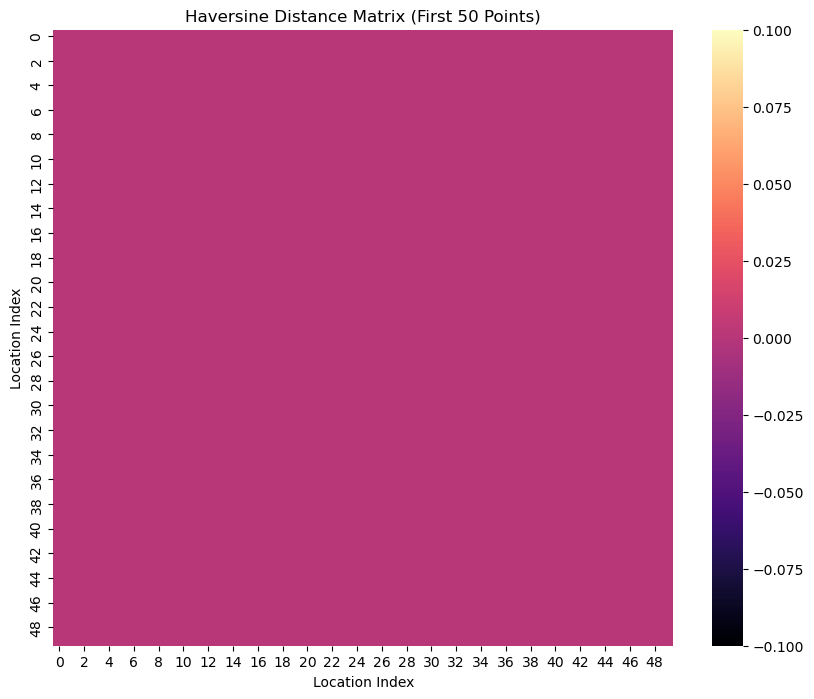

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix_km[:50, :50], cmap="magma")
plt.title("Haversine Distance Matrix (First 50 Points)")
plt.xlabel("Location Index")
plt.ylabel("Location Index")
plt.show()


In [21]:
df["bucket_x"] = (df["lon"] * 10).astype("int32")
df["bucket_y"] = (df["lat"] * 10).astype("int32")
df["bucket"] = df["bucket_x"].astype("str") + "_" + df["bucket_y"].astype("str")


In [22]:
density = df.groupby("bucket").size().rename("count")


In [23]:
from cuml.cluster import DBSCAN

# Drop rows with missing coordinates
df_cluster = df.dropna(subset=["lon", "lat"]).copy()

# Convert to float32 (cuML requirement)
X = df_cluster[["lon", "lat"]].astype("float32")

# Apply DBSCAN (e.g., epsilon 3km, min_samples 10)
db = DBSCAN(eps=3.0, min_samples=10)
df_cluster["cluster"] = db.fit_predict(X)

# Merge back with full dataframe
df = df.merge(df_cluster[["lon", "lat", "cluster"]], on=["lon", "lat"], how="left")


[W] [12:23:55.112166] Batch size limited by the chosen integer type (4 bytes). 34037 -> 26979. Using the larger integer type might result in better performance


In [24]:
# Ensure the 'month' column exists
df['month'] = df['Date_reported'].dt.month

# Group by cluster and month
monthly_clusters = df.dropna(subset=["cluster"]).groupby(["cluster", "month"]).agg({
    "New_cases": "sum"
})


In [26]:
df_centroids = df.groupby('cluster')[['lon', 'lat']].mean().reset_index()


In [28]:
# 1. Convert only 1000 rows to CPU to avoid GPU memory overload
import pandas as pd

# This will bypass GPU memory limits
pdf_sample = df.head(1000).to_pandas().copy()

# 2. Clean and prepare necessary columns
pdf_sample["prev_lat"] = pdf_sample["lat"].shift(1)
pdf_sample["prev_lon"] = pdf_sample["lon"].shift(1)

# 3. Drop missing values created by shift
pdf_sample.dropna(subset=["prev_lat", "prev_lon"], inplace=True)

# ✅ This is your clean, CPU-based working sample
print(pdf_sample[["lat", "lon", "prev_lat", "prev_lon"]].head())


        lat       lon  prev_lat  prev_lon
1  56.26392  9.501785  56.26392  9.501785
2  56.26392  9.501785  56.26392  9.501785
3  56.26392  9.501785  56.26392  9.501785
4  56.26392  9.501785  56.26392  9.501785
5  56.26392  9.501785  56.26392  9.501785


In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances

# Create a fake time series if real Date_reported is unavailable
pdf_sample["Date_reported"] = pd.date_range(start="2020-01-01", periods=len(pdf_sample), freq="D")

# Compute time difference in days
pdf_sample["prev_time"] = pdf_sample["Date_reported"].shift(1)
pdf_sample["time_diff_days"] = (pdf_sample["Date_reported"] - pdf_sample["prev_time"]).dt.days.fillna(0) + 0.01

# Convert coordinates to radians
p1 = np.radians(pdf_sample[["prev_lat", "prev_lon"]].values)
p2 = np.radians(pdf_sample[["lat", "lon"]].values)

# Haversine distance (in km)
pdf_sample["distance_to_prev"] = np.diag(haversine_distances(p1, p2)) * 6371.0

# Velocity = distance / time
pdf_sample["velocity_km_per_day"] = pdf_sample["distance_to_prev"] / pdf_sample["time_diff_days"]


In [30]:
pdf_sample["is_fast_spread"] = pdf_sample["velocity_km_per_day"] > 100


In [31]:
pdf_sample["dx"] = pdf_sample["lon"] - pdf_sample["prev_lon"]
pdf_sample["dy"] = pdf_sample["lat"] - pdf_sample["prev_lat"]
pdf_sample["angle_deg"] = np.degrees(np.arctan2(pdf_sample["dy"], pdf_sample["dx"]))


In [32]:
buffer_km = 300
pdf_sample["buffer_lat"] = pdf_sample["lat"] + (buffer_km / 111.0)
pdf_sample["buffer_lon"] = pdf_sample["lon"] + (buffer_km / (111.0 * np.cos(np.radians(pdf_sample["lat"]))))


In [33]:
pdf_sample["close_to_prev"] = pdf_sample["distance_to_prev"] < 300


In [34]:
# Compute dx and dy for direction
pdf_sample["dx"] = pdf_sample["lon"] - pdf_sample["prev_lon"]
pdf_sample["dy"] = pdf_sample["lat"] - pdf_sample["prev_lat"]

# Angle in degrees from East (atan2 gives result in radians)
pdf_sample["angle_deg"] = np.degrees(np.arctan2(pdf_sample["dy"], pdf_sample["dx"]))


In [35]:
# Simulate 10 fake clusters
pdf_sample["fake_cluster"] = pd.cut(pdf_sample.index, bins=10, labels=False)

# Compute cluster centroids
cluster_centroids = pdf_sample.groupby("fake_cluster")[["lat", "lon"]].mean().reset_index()

# Compute pairwise distances between adjacent cluster centroids
lat1 = np.radians(cluster_centroids["lat"].values[:-1])
lon1 = np.radians(cluster_centroids["lon"].values[:-1])
lat2 = np.radians(cluster_centroids["lat"].values[1:])
lon2 = np.radians(cluster_centroids["lon"].values[1:])

from sklearn.metrics.pairwise import haversine_distances

p1 = np.column_stack((lat1, lon1))
p2 = np.column_stack((lat2, lon2))

cluster_centroids["inter_cluster_dist_km"] = np.append(
    np.diag(haversine_distances(p1, p2)) * 6371, 0
)


In [36]:
# Sum cases per cluster and divide by an approximate area (πr²), assume r = 10 km
pdf_sample["cluster_cases"] = pdf_sample.groupby("fake_cluster")["New_cases"].transform("sum")
pdf_sample["cases_density"] = pdf_sample["cluster_cases"] / (np.pi * 10**2)


In [37]:
# Shift and compute jump
pdf_sample["density_jump"] = pdf_sample["cases_density"].diff().fillna(0)
pdf_sample["is_jump"] = np.abs(pdf_sample["density_jump"]) > 0.5 * pdf_sample["cases_density"]


In [38]:
# Identify travel corridors that fall within dangerous angles
pdf_sample["is_directional_threat"] = pdf_sample["angle_deg"].between(30, 150)


In [39]:
# Create synthetic dates
pdf_sample["Date_reported"] = pd.date_range(start="2020-01-01", periods=len(pdf_sample), freq="D")
lifespan = pdf_sample.groupby("fake_cluster")["Date_reported"].agg(["min", "max"])
lifespan["lifespan_days"] = (lifespan["max"] - lifespan["min"]).dt.days


In [40]:
# Create a fake velocity and radius if not available
pdf_sample["velocity_km_per_day"] = pdf_sample["distance_to_prev"] / (pdf_sample["Date_reported"].diff().dt.days.fillna(1))
pdf_sample["radius_km"] = np.random.uniform(5, 20, size=len(pdf_sample))

# Composite score
pdf_sample["risk_score"] = (pdf_sample["cases_density"] * pdf_sample["velocity_km_per_day"]) / (pdf_sample["radius_km"] + 1)

# Categorize risk
pdf_sample["risk_tier"] = pd.cut(
    pdf_sample["risk_score"],
    bins=[-np.inf, 500, 2000, np.inf],
    labels=["Low", "Medium", "High"]
)


In [41]:
# Simulate two hospital coordinates
hosp_coords = [(77.1, 28.6), (72.8, 19.1)]  # (lon, lat)

# Compute distances using haversine
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

pdf_sample["dist_to_hosp1"] = haversine_np(
    pdf_sample["lon"], pdf_sample["lat"], hosp_coords[0][0], hosp_coords[0][1]
)
pdf_sample["dist_to_hosp2"] = haversine_np(
    pdf_sample["lon"], pdf_sample["lat"], hosp_coords[1][0], hosp_coords[1][1]
)


In [42]:
# Composite heatmap score
pdf_sample["heatmap_value"] = (
    pdf_sample["New_cases"] / (pdf_sample["radius_km"] + 1)
) * np.log1p(pdf_sample["velocity_km_per_day"])


In [125]:
pdf_sample.to_csv("cleaned_sample.csv", index=False)


In [43]:
# Step 15.5: Compute direction angle (in degrees) using dx, dy
pdf_sample["dx"] = pdf_sample["lon"] - pdf_sample["prev_lon"]
pdf_sample["dy"] = pdf_sample["lat"] - pdf_sample["prev_lat"]
pdf_sample["angle"] = np.degrees(np.arctan2(pdf_sample["dy"], pdf_sample["dx"]))


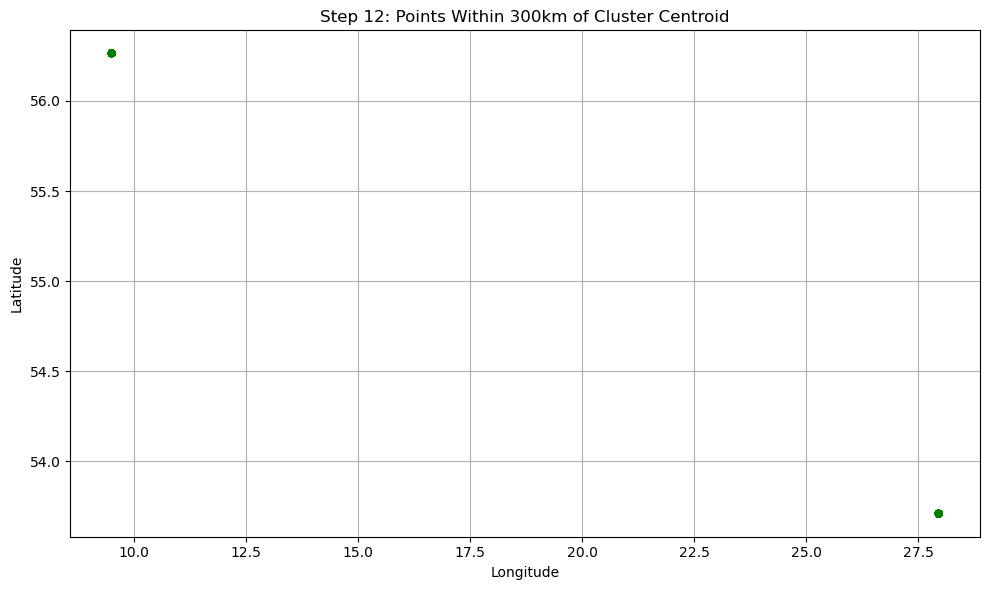

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure you have a DataFrame called `pdf_sample` with these columns:
# ['lat', 'lon', 'radius_km']

# Step 12: Mark points within 300 km of their cluster centroid
pdf_sample["close_to_centroid"] = pdf_sample["radius_km"] < 300

# Map boolean to color
colors = pdf_sample["close_to_centroid"].map({True: "green", False: "gray"})

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(pdf_sample["lon"], pdf_sample["lat"], c=colors, s=20, alpha=0.7)
plt.title("Step 12: Points Within 300km of Cluster Centroid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=2.5, min_samples=5)
pdf_sample["cluster"] = model.fit_predict(pdf_sample[["lon", "lat"]])


/home/deepak/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


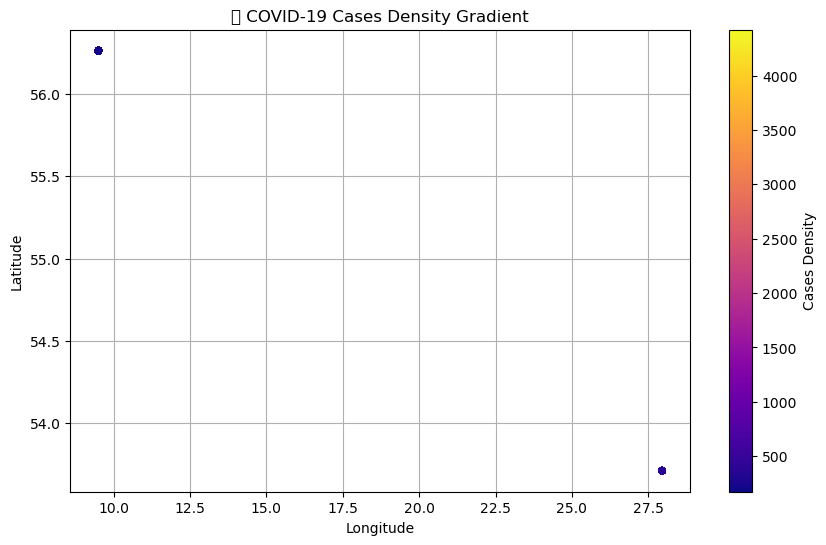

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pdf_sample["lon"], pdf_sample["lat"], c=pdf_sample["cases_density"], cmap="plasma", s=20)
plt.colorbar(label="Cases Density")
plt.title("🧭 COVID-19 Cases Density Gradient")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


/home/deepak/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


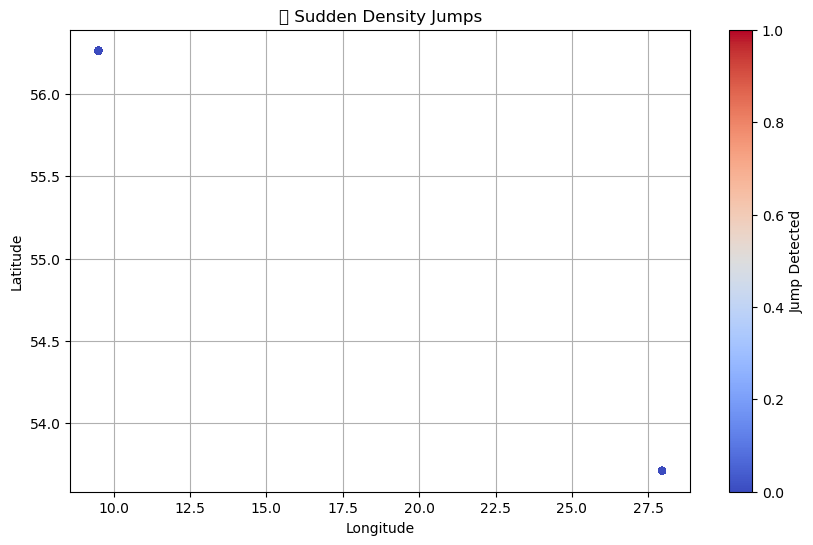

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(pdf_sample["lon"], pdf_sample["lat"], c=pdf_sample["is_jump"], cmap="coolwarm", s=20)
plt.colorbar(label="Jump Detected")
plt.title("🚨 Sudden Density Jumps")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


/home/deepak/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


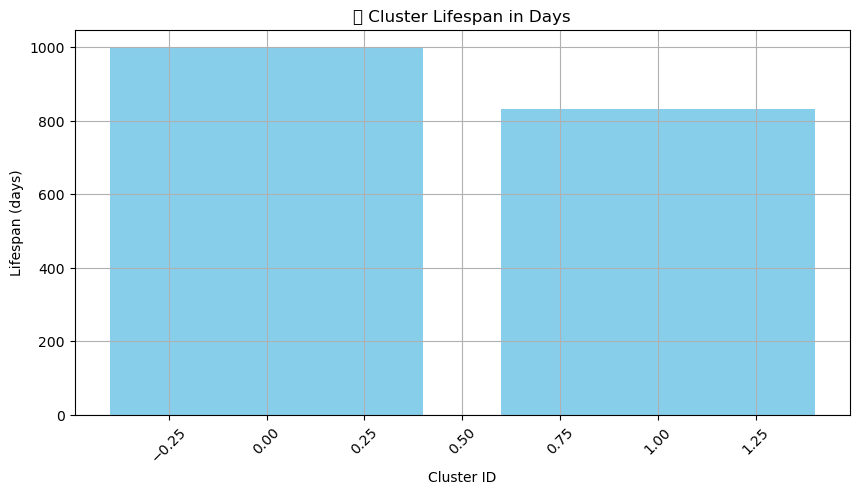

In [48]:
# If not already done:
# Group by cluster and compute lifespan
lifespan = pdf_sample.groupby("cluster")["Date_reported"].agg(["min", "max"])
lifespan["lifespan_days"] = (lifespan["max"] - lifespan["min"]).dt.days
lifespan = lifespan.reset_index()

# 📊 Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(lifespan["cluster"], lifespan["lifespan_days"], color="skyblue")
plt.title("📆 Cluster Lifespan in Days")
plt.xlabel("Cluster ID")
plt.ylabel("Lifespan (days)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/home/deepak/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


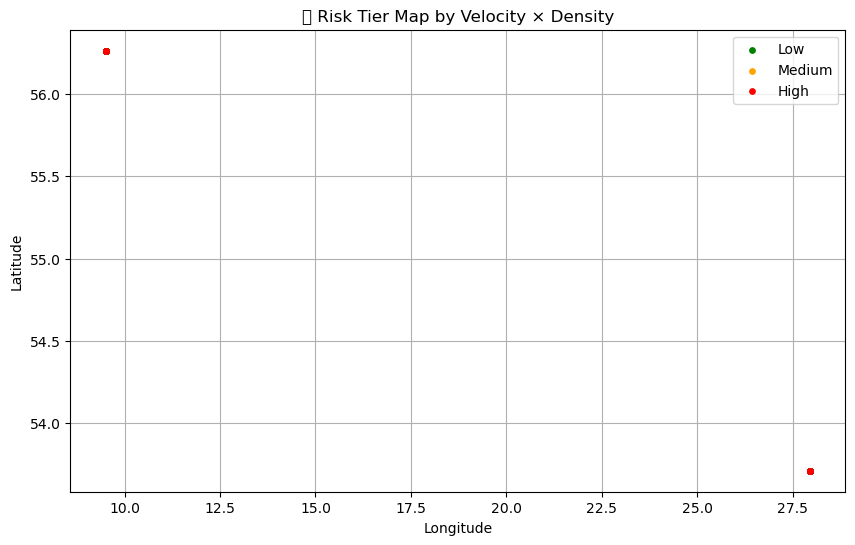

In [49]:
colors = {'High': 'red', 'Medium': 'orange', 'Low': 'green'}
plt.figure(figsize=(10, 6))
for tier, group in pdf_sample.groupby("risk_tier"):
    plt.scatter(group["lon"], group["lat"], label=tier, color=colors[tier], s=15)

plt.legend()
plt.title("🛑 Risk Tier Map by Velocity × Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


/home/deepak/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


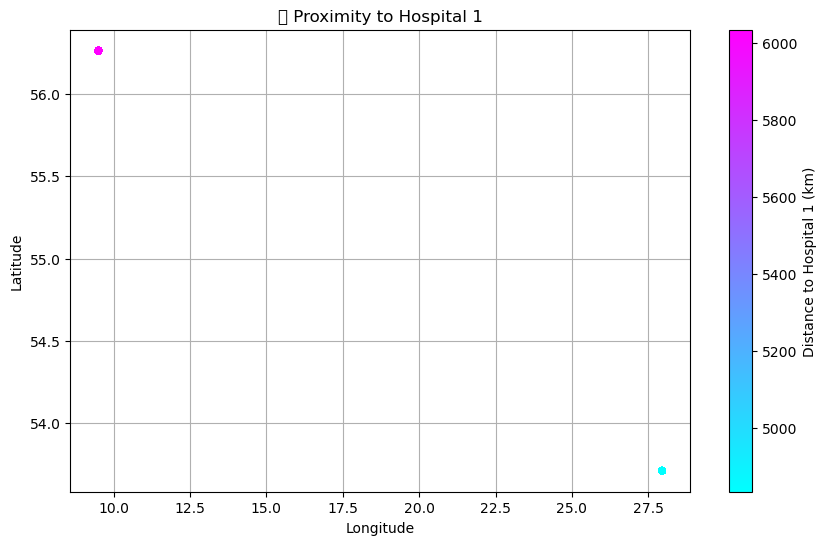

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(pdf_sample["lon"], pdf_sample["lat"], c=pdf_sample["dist_to_hosp1"], cmap="cool", s=20)
plt.colorbar(label="Distance to Hospital 1 (km)")
plt.title("🏥 Proximity to Hospital 1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


/home/deepak/miniconda3/envs/cuspatial_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


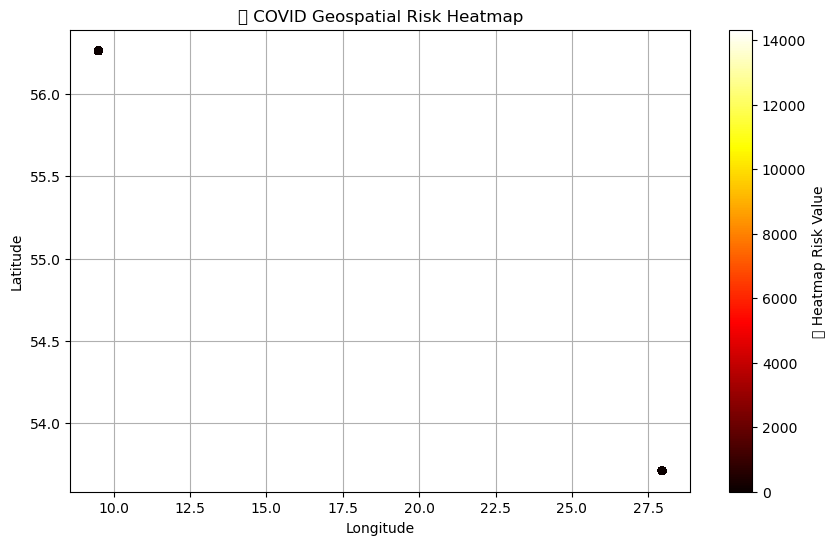

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(pdf_sample["lon"], pdf_sample["lat"], c=pdf_sample["heatmap_value"], cmap="hot", s=25)
plt.colorbar(label="🔥 Heatmap Risk Value")
plt.title("🔥 COVID Geospatial Risk Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [52]:
import plotly.express as px
import pandas as pd

# 1. Compute cluster centroids again if needed
cluster_centroids = pdf_sample.groupby("cluster")[["lat", "lon"]].mean().reset_index()

# 2. Compute lifespan as before
lifespan = pdf_sample.groupby("cluster")["Date_reported"].agg(["min", "max"])
lifespan["lifespan_days"] = (lifespan["max"] - lifespan["min"]).dt.days
lifespan = lifespan.reset_index()

# 3. Merge lifespan with centroids for plotting
lifespan_map = pd.merge(cluster_centroids, lifespan, on="cluster")

# 4. Plot on world map
fig = px.scatter_geo(
    lifespan_map,
    lat="lat",
    lon="lon",
    color="lifespan_days",
    size="lifespan_days",
    projection="natural earth",
    title="🌍 Cluster Lifespan Mapped Globally",
    color_continuous_scale="Viridis",
    hover_name="cluster",
    size_max=20,
)

fig.update_layout(geo=dict(showland=True, showcountries=True))
fig.show()


In [53]:
import plotly.express as px
import plotly.graph_objects as go

# Ensure you have latitude, longitude, and cluster/risk values in your DataFrame
print(pdf_sample.columns)  # preview to ensure necessary columns like 'lon', 'lat', 'cluster', etc. exist


Index(['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases',
       'Cumulative_cases', 'New_deaths', 'Cumulative_deaths', 'country_code',
       'lat', 'lon', 'usa_state_code', 'usa_state_latitude',
       'usa_state_longitude', 'usa_state', 'prev_lat', 'prev_lon', 'bucket_x',
       'bucket_y', 'bucket', 'cluster', 'month', 'prev_time', 'time_diff_days',
       'distance_to_prev', 'velocity_km_per_day', 'is_fast_spread', 'dx', 'dy',
       'angle_deg', 'buffer_lat', 'buffer_lon', 'close_to_prev',
       'fake_cluster', 'cluster_cases', 'cases_density', 'density_jump',
       'is_jump', 'is_directional_threat', 'radius_km', 'risk_score',
       'risk_tier', 'dist_to_hosp1', 'dist_to_hosp2', 'heatmap_value', 'angle',
       'close_to_centroid'],
      dtype='object')


In [54]:
fig = px.scatter_geo(
    pdf_sample,
    lat="lat",
    lon="lon",
    color="cluster",  # Requires that clustering step has been done
    hover_name="cluster",
    title="COVID-19 Clusters on World Map",
    projection="natural earth",
    template="plotly_dark"
)
fig.update_traces(marker=dict(size=6))
fig.show()

In [55]:
fig = px.scatter_geo(
    pdf_sample,
    lat="lat",
    lon="lon",
    color="velocity_km_per_day",
    title="Spread Velocity (km/day)",
    projection="natural earth",
    template="plotly_dark",
    color_continuous_scale="Turbo"
)
fig.update_traces(marker=dict(size=5))
fig.show()


In [56]:
# Calculate risk score (Step 18)
pdf_sample["risk_score"] = (
    pdf_sample["cases_density"] * pdf_sample["velocity_km_per_day"]
) / (pdf_sample["radius_km"] + 1)

# Tiering
import numpy as np
pdf_sample["risk_tier"] = np.where(
    pdf_sample["risk_score"] > 2000, "High",
    np.where(pdf_sample["risk_score"] > 500, "Medium", "Low")
)


In [57]:
fig = px.scatter_geo(
    pdf_sample,
    lat="lat",
    lon="lon",
    color="risk_tier",
    title="COVID-19 Risk Tier Map",
    projection="natural earth",
    template="plotly_white",
    color_discrete_map={
        "High": "red",
        "Medium": "orange",
        "Low": "green"
    }
)
fig.update_traces(marker=dict(size=7, line=dict(width=0)))
fig.show()


In [58]:
pdf_sample["month"] = pd.to_datetime(pdf_sample["Date_reported"]).dt.to_period("M").astype(str)

fig = px.scatter_geo(
    pdf_sample,
    lat="lat",
    lon="lon",
    color="risk_tier",
    animation_frame="month",
    title="COVID-19 Risk Evolution Over Time",
    projection="natural earth",
    template="plotly_white",
    color_discrete_map={"High": "red", "Medium": "orange", "Low": "green"}
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [59]:
import numpy as np

# Define buffer radius (in km)
buffer_radius_km = 300

# Calculate degree deltas
pdf_sample["buffer_lat"] = pdf_sample["lat"] + (buffer_radius_km / 111.0)
pdf_sample["buffer_lon"] = pdf_sample["lon"] + (buffer_radius_km / (111.0 * np.cos(np.radians(pdf_sample["lat"]))))


In [60]:
import plotly.graph_objects as go

# Create scatter points for original locations
points_trace = go.Scattergeo(
    lon=pdf_sample["lon"],
    lat=pdf_sample["lat"],
    mode="markers",
    name="Original Points",
    marker=dict(color="red", size=4),
    hoverinfo="text",
    text=pdf_sample["cluster"]
)

# Create buffer point markers (representing edge of buffer)
buffer_trace = go.Scattergeo(
    lon=pdf_sample["buffer_lon"],
    lat=pdf_sample["buffer_lat"],
    mode="markers",
    name="300 km Buffer Edge",
    marker=dict(color="blue", size=4, symbol="circle-open"),
    hoverinfo="skip"
)

fig = go.Figure(data=[points_trace, buffer_trace])

fig.update_layout(
    title="COVID Points with 300 km Buffer Zones (Approx)",
    geo=dict(
        projection_type="natural earth",
        showland=True,
        landcolor="rgb(229, 229, 229)",
        subunitcolor="rgb(255, 255, 255)",
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
        showocean=True,
        oceancolor="lightblue",
    ),
    template="plotly_white"
)

fig.show()
